Encoder:  Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=832000, out_features=200, bias=True)
  (fc2): Linear(in_features=832000, out_features=200, bias=True)
)
Decoder:  Decoder(
  (fc): Linear(in_features=200, out_features=832000, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(64,

Training:   5%|▌         | 1/20 [34:34<10:56:55, 2074.51s/it]

Epoch 1, train_loss=7.471524687422251, valid_loss=5.558874290022193, Time: 2074.51s


Training:  10%|█         | 2/20 [52:49<7:29:29, 1498.32s/it] 

Epoch 2, train_loss=4.2900972144719685, valid_loss=4.851615891394169, Time: 1094.98s


Training:  15%|█▌        | 3/20 [1:11:19<6:14:16, 1321.00s/it]

Epoch 3, train_loss=3.7421658601749486, valid_loss=4.671403368972307, Time: 1109.98s


Training:  20%|██        | 4/20 [1:29:38<5:28:51, 1233.22s/it]

Epoch 4, train_loss=3.455306743504202, valid_loss=4.469421324584739, Time: 1098.65s


Training:  25%|██▌       | 5/20 [1:48:10<4:57:26, 1189.74s/it]

Epoch 5, train_loss=3.278293123458922, valid_loss=4.473845983006672, Time: 1112.65s


Training:  30%|███       | 6/20 [2:06:28<4:30:17, 1158.41s/it]

Epoch 6, train_loss=3.1404406070676254, valid_loss=4.387225948573851, Time: 1097.60s


Training:  35%|███▌      | 7/20 [2:24:10<4:04:10, 1126.99s/it]

Epoch 7, train_loss=3.033418076532296, valid_loss=4.327847590712008, Time: 1062.31s


Training:  40%|████      | 8/20 [2:41:54<3:41:23, 1106.99s/it]

Epoch 8, train_loss=2.9416543151734578, valid_loss=4.33458813640819, Time: 1064.15s


Training:  45%|████▌     | 9/20 [2:59:38<3:20:27, 1093.43s/it]

Epoch 9, train_loss=2.863242481129168, valid_loss=4.318185416169113, Time: 1063.62s


Training:  50%|█████     | 10/20 [3:17:20<3:00:36, 1083.61s/it]

Epoch 10, train_loss=2.797988071865553, valid_loss=4.308592388016471, Time: 1061.63s


Training:  55%|█████▌    | 11/20 [3:35:26<2:42:41, 1084.59s/it]

Epoch 11, train_loss=2.7412458630976317, valid_loss=4.249299632805269, Time: 1086.82s


Training:  60%|██████    | 12/20 [3:54:03<2:25:53, 1094.19s/it]

Epoch 12, train_loss=2.691590374343485, valid_loss=4.272956452924082, Time: 1116.15s


Training:  65%|██████▌   | 13/20 [4:12:21<2:07:48, 1095.55s/it]

Epoch 13, train_loss=2.6453938474043617, valid_loss=4.230029397778828, Time: 1098.66s


Training:  70%|███████   | 14/20 [4:30:39<1:49:36, 1096.08s/it]

Epoch 14, train_loss=2.604458250417182, valid_loss=4.245518256670519, Time: 1097.31s


Training:  75%|███████▌  | 15/20 [4:48:56<1:31:22, 1096.51s/it]

Epoch 15, train_loss=2.5677716071612156, valid_loss=4.219599715127687, Time: 1097.52s


Training:  80%|████████  | 16/20 [5:07:19<1:13:14, 1098.50s/it]

Epoch 16, train_loss=2.5353120071487605, valid_loss=4.209783848875196, Time: 1103.12s


Training:  85%|████████▌ | 17/20 [5:25:40<54:57, 1099.14s/it]  

Epoch 17, train_loss=2.5060058383315442, valid_loss=4.213319569398297, Time: 1100.64s


Training:  90%|█████████ | 18/20 [5:43:55<36:35, 1097.93s/it]

Epoch 18, train_loss=2.4753922151032435, valid_loss=4.204237601418171, Time: 1095.09s


Training:  95%|█████████▌| 19/20 [6:02:29<18:22, 1102.89s/it]

Epoch 19, train_loss=2.4531748161023095, valid_loss=4.222372261013663, Time: 1114.44s


Training: 100%|██████████| 20/20 [6:20:53<00:00, 1142.68s/it]

Epoch 20, train_loss=2.4275358424596676, valid_loss=4.216125067297001, Time: 1103.69s
Training complete. Saving results...


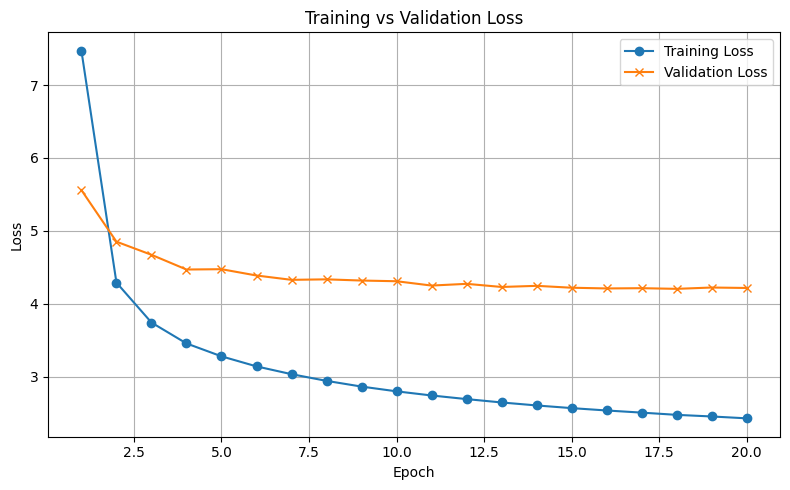

In [ ]:
%run init_notebook.py

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T
import time
import torchaudio
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import Audio, display

from src.dataset import NSynth   
from src.models import AutoEncoder
from src.utils.dataset import load_raw_waveform
from src.utils.logger import save_training_results
from src.utils.models import compute_magnitude_and_phase

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r"C:\Users\Articuno\Desktop\TFG-info\data\models\autoencoder.pth"

# STFT transform
sample_rate = 16000
n_fft = 4000 # Small n_fft: good time resolution, poor frequency resolution. Large n_fft: good frequency resolution, poor time resolution.
hop_length = 300
win_length = n_fft  # Same as n_fft

# Apply the correct transform for magnitude and phase (onesided=False to handle complex spectrogram)
stft_transform = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=None,  # Keep as complex spectrogram (magnitude and phase)
    onesided=False,  # Make sure we keep the full spectrum (complex-valued)
    center=False
).to(device)

# Define the inverse STFT function (onesided=False)
istft_transform = torchaudio.transforms.InverseSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    onesided=False  # Make sure we reconstruct using the full complex spectrogram
).to(device)

# Datasets and DataLoaders, training parameters.
train_dataset = NSynth(partition='training')
valid_dataset = NSynth(partition='validation')
test_dataset  = NSynth(partition='testing')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

input_height = 4000 # = n_fft because onesided=False
input_width  = 201 # = 1 + floor((T - n_ftt) / hop_length), where T is the whole duration (4 * 16000 = 64000)
latent_dim   = 200
channels = [2, 16, 32, 64]
learning_rate = 1e-4

model = AutoEncoder((input_height, input_width), latent_dim).to(device)

if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model loaded successfully.")
    except PermissionError as e:
        print(f"PermissionError: {e}. Unable to load the model.")
else:
    print("No saved model found, starting training from scratch.")

    # Model, Optimizer, and Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss().to(device)

    # Training Loop
    num_epochs = 20
    log_interval = 10
    avg_epoch_time = 0.0

    training_losses = []
    validation_losses = []

    # Learning rate scheduler to reduce learning rate based on validation loss
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    print(f"Starting training on {device}...")
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        start_epoch_time = time.time()
        train_loss = 0.0
        
        # Training Loop
        for i, (waveform, _, _, _) in enumerate(train_loader):
            # waveform has shape [batch_size, 1, time_steps]

            waveform = waveform.to(device)

            # Apply STFT transformation
            stft_spec = stft_transform(waveform)  # [batch_size, 1, freq_bins, time_frames]

            # Extract magnitude and phase
            magnitude, phase = compute_magnitude_and_phase(stft_spec)

            input_data = torch.cat([magnitude, phase], dim=1).to(device)  # [batch_size, 2, freq_bins, time_frames]

            optimizer.zero_grad()
            output = model(input_data)  # shape [batch_size, 2, freq_bins, time_frames]

            loss = criterion(output, input_data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * waveform.size(0)

        # Compute average epoch loss for training
        train_loss /= len(train_loader.dataset)

        # Validation Loop
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for i, (waveform, _, _, _) in enumerate(valid_loader):
                waveform = waveform.to(device)
                stft_spec = stft_transform(waveform)
                
                # Extract magnitude and phase
                magnitude, phase = compute_magnitude_and_phase(stft_spec)
                input_data = torch.cat([magnitude, phase], dim=1).to(device)

                output = model(input_data)
                loss = criterion(output, input_data)
                valid_loss += loss.item() * waveform.size(0)

        # Compute average validation loss
        valid_loss /= len(valid_loader.dataset)
        
        # Step the scheduler with validation loss
        scheduler.step(valid_loss)

        epoch_time = time.time() - start_epoch_time
        avg_epoch_time += epoch_time
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch+1}, train_loss={train_loss}, valid_loss={valid_loss}, Time: {epoch_time:.2f}s")
            
    print("Training complete. Saving results...")

    save_training_results({
        "train_loss": training_losses,
        "valid_loss": validation_losses,
        "num_epochs": num_epochs,
        "avg_epoch_time": avg_epoch_time / num_epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "sample_rate": sample_rate,
        "n_fft": n_fft,
        "hop_length": hop_length,
        "input_height": input_height,
        "input_width": input_width,
        "latent_dim": latent_dim,
    }, "autoencoder.json")

    torch.save(model.state_dict(), model_path)
    # Plot training and validation losses
    import matplotlib.pyplot as plt
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_losses, label='Training Loss', marker='o')
    plt.plot(epochs, validation_losses, label='Validation Loss', marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




### Reconstruction Accuracy

The **reconstruction accuracy** for each sample is computed as:

$$
\text{Accuracy}_i = \max \left(0, 1 - \frac{\lVert x_i - \hat{x}_i \rVert_2^2}{\lVert x_i \rVert_2^2 + \varepsilon} \right) \times 100\%
$$

where:
- $x_i$ is the input for sample $i$ (of shape `[batch_size, 2, num_freq, time_frames]`),
- $\hat{x}_i$ is the reconstructed output from the model,
- $\lVert \cdot \rVert_2^2$ denotes the squared L2 norm (i.e., the sum of squared elements),
- $\varepsilon$ is a small constant to avoid division by zero.

This gives a value between 0% and 100% for each sample.

---

### Total Accuracy

To compute the **overall accuracy** across all samples in the dataset (or batch-wise using a DataLoader), we take the average of all per-sample accuracies:

$$
\text{Total Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \text{Accuracy}_i
$$

where $N$ is the total number of samples evaluated.

This metric tells us how well the model reconstructs the inputs **on average** over the dataset.


In [2]:
def reconstruction_accuracy(x, x_hat):
    # Compute per-sample accuracy tensor of shape [B]
    numerator = torch.sum((x - x_hat) ** 2, dim=(1, 2, 3))
    denominator = torch.sum(x ** 2, dim=(1, 2, 3)) + 1e-8
    accuracy = 1 - numerator / denominator
    return torch.clamp(accuracy, min=0.0, max=1.0)


model.eval()
total_acc_sum = 0.0
total_samples = 0

with torch.no_grad():
    for (waveform, _, _, _) in test_loader:
        raw_waveform = waveform.to(device)  # shape: [B, 1, T]

        stft_spec = stft_transform(raw_waveform)
        magnitude, phase = compute_magnitude_and_phase(stft_spec)
        input = torch.cat([magnitude, phase], dim=1)

        output = model(input)

        batch_acc = reconstruction_accuracy(input, output)  # shape: [B]
        total_acc_sum += batch_acc.sum().item()
        total_samples += waveform.size(0)

test_accuracy = round((total_acc_sum / total_samples) * 100, 2)
print(f"Testing accuracy: {test_accuracy}%")

Testing accuracy: 70.99%


In [3]:
# --------------------------
# Audio Playback
# --------------------------

from src.config import MAX_MAGNITUDE, MAX_PHASE

model.eval()

# Samples to compare
test_indices = [random.choice(range(len(test_dataset))) for _ in range(10)]

for idx in test_indices:
    print(f"\n=== Test sample index: {idx} ===")
    # (stft_spec, sample_rate, key, metadata) from dataset; here we only need key and sample_rate
    _, sample_rate, key, metadata = test_dataset[idx]

    # Listen to the Original Audio with no transform applied
    raw_waveform, raw_sr = load_raw_waveform("testing", key)
    print(f"Key: {key}")
    print("Original audio:")
    display(Audio(raw_waveform.numpy(), rate=raw_sr))

    # Ensure raw_waveform has a batch and channel dimension, expected shape: [batch, 1, time_steps]
    if raw_waveform.ndim == 2:  # e.g., [1, time_steps]
        raw_waveform = raw_waveform.unsqueeze(0)
    
    raw_waveform = raw_waveform.to(device)

    # Apply STFT transformation
    stft_spec = stft_transform(raw_waveform)  # [batch, 1, freq_bins, time_frames]
    
    # Extract magnitude and phase using the helper function
    magnitude, phase = compute_magnitude_and_phase(stft_spec)  # both: [batch, 1, freq_bins, time_frames]
    input_data = torch.cat([magnitude, phase], dim=1).to(device)
    
    # Reconstruct using the model
    with torch.no_grad():
        output_data = model(input_data)  # shape: [batch, 2, freq_bins, time_frames]
    
    # Split the network output into magnitude and phase
    recon_magnitude = output_data[:, 0, :, :]  # [batch, freq_bins, time_frames]
    recon_phase = output_data[:, 1, :, :]      # [batch, freq_bins, time_frames]

    # Recombine into a complex spectrogram
    recon_complex = recon_magnitude * torch.exp(1j * recon_phase)
    
    # Apply the inverse STFT transformation to get the waveform
    reconstructed_waveform = istft_transform(recon_complex)  # [batch, time_steps]
    
    print("Reconstructed audio:")
    display(Audio(reconstructed_waveform.squeeze().cpu().numpy(), rate=raw_sr))


=== Test sample index: 3983 ===
Key: organ_electronic_113-082-025
Original audio:


Reconstructed audio:



=== Test sample index: 666 ===
Key: vocal_acoustic_000-060-075
Original audio:


Reconstructed audio:



=== Test sample index: 1089 ===
Key: guitar_electronic_028-085-100
Original audio:


Reconstructed audio:



=== Test sample index: 2539 ===
Key: keyboard_electronic_001-023-075
Original audio:


Reconstructed audio:



=== Test sample index: 1903 ===
Key: brass_acoustic_006-036-025
Original audio:


Reconstructed audio:



=== Test sample index: 3077 ===
Key: bass_synthetic_033-064-025
Original audio:


Reconstructed audio:



=== Test sample index: 2177 ===
Key: guitar_acoustic_010-077-025
Original audio:


Reconstructed audio:



=== Test sample index: 322 ===
Key: guitar_electronic_022-063-025
Original audio:


Reconstructed audio:



=== Test sample index: 3183 ===
Key: guitar_acoustic_015-048-025
Original audio:


Reconstructed audio:



=== Test sample index: 3163 ===
Key: keyboard_electronic_069-066-100
Original audio:


Reconstructed audio:
